In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numba as nb
import rosbag
import pymap3d as pm

Failed to load Python extension for LZ4 support. LZ4 compression will not be available.


In [2]:
def wrap_angle(angle):
    return (angle + np.pi) % (2 * np.pi) - np.pi

@nb.njit()
def to_euler(x, y, z, w):
    """Dari Coursera: Return as xyz (roll pitch yaw) Euler angles."""
    roll = np.arctan2(2 * (w * x + y * z), 1 - 2 * (x**2 + y**2))
    pitch = np.arcsin(2 * (w * y - z * x))
    yaw = np.arctan2(2 * (w * z + x * y), 1 - 2 * (y**2 + z**2))
    return np.array([roll, pitch, yaw])
# Compile the to_euler
_ = to_euler(1.5352300785980803e-15, -1.3393747145983517e-15, -0.7692164172827881, 0.638988343698562)

def calculate_s(wp_x, wp_y):
    s = np.zeros(wp_x.shape[0])
    for i in range(1, s.shape[0]):
        s[i] = s[i-1] + np.sqrt((wp_x[i] - wp_x[i-1])**2 + (wp_y[i] - wp_y[i-1])**2)
    return s

In [3]:
bag = rosbag.Bag('data_fixed/belok_1.bag')
# bag = rosbag.Bag('data_fixed/lurus_s_1.bag')
# bag = rosbag.Bag('data_fixed/lurus_s_2.bag')
# bag = rosbag.Bag('data_fixed/lurus_s_3.bag')
# bag = rosbag.Bag('data_fixed/lurus_s_4.bag')
# bag = rosbag.Bag('data_fixed/lurus_s_5.bag')
#print(bag)

# DATA

In [4]:
lat0, lon0, h0 = -6.8712, 107.5738, 768
gps_t = []
gps_pos = []
gps_cov = []
for topic, msg, _ in bag.read_messages(topics=['/fix']):
    gps_t.append(msg.header.stamp.to_sec())
    gps_pos.append(pm.geodetic2enu(msg.latitude, msg.longitude, msg.altitude, lat0, lon0, h0))
    gps_cov.append(msg.position_covariance)
gps_t = np.array(gps_t)
gps_pos = np.array(gps_pos)
gps_cov = np.array(gps_cov).reshape(-1,3,3)

# Ambil sb. x & sb. y saja sampai limm
limm = -1
#X_fm = (-1) * np.copy(gps_pos[:limm,:2])
X_fm = np.copy(gps_pos[:limm,:2])
ttime = np.copy(gps_t[:limm])

gnss_t = np.copy(gps_t[:limm])
gnss_p = np.copy(gps_pos[:limm, :2])

In [5]:
imu_t = []
imu_a = []
imu_w = []
imu_q = []
imu_rpy = []
for topic, msg, _ in bag.read_messages(topics=['/android/imu']):
    imu_t.append(msg.header.stamp.to_sec())
    acc = msg.linear_acceleration
    imu_a.append([acc.x, acc.y, acc.z])
    acc = msg.angular_velocity
    imu_w.append([acc.x, acc.y, acc.z])
    q = msg.orientation
    imu_q.append([q.x, q.y, q.z, q.w])
    imu_rpy.append(to_euler(q.x, q.y, q.z, q.w))
imu_t = np.array(imu_t)
imu_a = np.array(imu_a)
imu_w = np.array(imu_w)
imu_q = np.array(imu_q)
imu_rpy = np.array(imu_rpy)

In [6]:
cs_t = []
cs_action_throttle = []
cs_action_steer = []
cs_error_lateral = []
cs_error_yaw = []
cs_actual_x = []
cs_actual_y = []
cs_actual_yaw = []
cs_actual_speed = []
cs_ref_x = []
cs_ref_y = []
cs_ref_yaw = []
cs_ref_curvature = []
cs_wp_idx = []
for topic, msg, _ in bag.read_messages(topics=['/control_signal']):
    cs_t.append(msg.header.stamp.to_sec())
    cs_action_throttle.append(msg.action_throttle)
    cs_action_steer.append(msg.action_steer)
    cs_error_lateral.append(msg.error_lateral)
    cs_error_yaw.append(msg.error_yaw)
    cs_actual_x.append(msg.actual_x)
    cs_actual_y.append(msg.actual_y)
    cs_actual_yaw.append(msg.actual_yaw)
    cs_actual_speed.append(msg.actual_speed)
    cs_ref_x.append(msg.ref_x)
    cs_ref_y.append(msg.ref_y)
    cs_ref_yaw.append(msg.ref_yaw)
    cs_ref_curvature.append(msg.ref_curvature)
    cs_wp_idx.append(msg.wp_idx)
cs_t = np.array(cs_t)
cs_action_throttle = np.array(cs_action_throttle)
cs_action_steer = np.array(cs_action_steer)
cs_error_lateral = np.array(cs_error_lateral)
cs_error_yaw = np.array(cs_error_yaw)
cs_actual_x = np.array(cs_actual_x)
cs_actual_y = np.array(cs_actual_y)
cs_actual_yaw = np.array(cs_actual_yaw)
cs_actual_speed = np.array(cs_actual_speed)
cs_ref_x = np.array(cs_ref_x)
cs_ref_y = np.array(cs_ref_y)
cs_ref_yaw = np.array(cs_ref_yaw)
cs_ref_curvature = np.array(cs_ref_curvature)
cs_wp_idx = np.array(cs_wp_idx)

# TEST

## 2D

In [7]:
def yaw_to_rot(y):
    return np.array([[np.cos(y), -np.sin(y)],
                     [np.sin(y), np.cos(y)]])

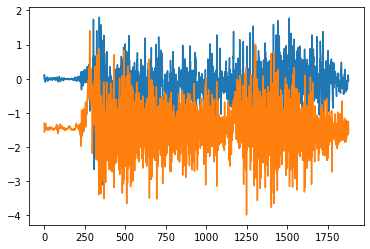

In [8]:
plt.plot(imu_a[:,:-1])

In [9]:
lim_b = 200
imu_a_2d = np.copy(imu_a[:,:-1])
imu_w_2d = np.copy(imu_w[:,-1])
bias_a_2d = np.mean(imu_a_2d[:lim_b], axis=0)
bias_w_2d = np.mean(imu_w[:lim_b])

In [10]:
print(bias_a_2d)
print(bias_w_2d)

[-0.00977362 -1.44911645]
-0.00018316499772481621


In [11]:
p_2d = np.zeros_like(imu_a_2d)
v_2d = np.zeros_like(imu_a_2d)
yaw = np.zeros(imu_a_2d.shape[0])
p_2d[0,0] = cs_actual_x[0]
p_2d[0,1] = cs_actual_y[0]
yaw[0] = imu_rpy[0,-1]
# yaw[0] = 3.092

In [12]:
for k in range(1, imu_a.shape[0]):
    dt = imu_t[k] - imu_t[k - 1]
    
    C = yaw_to_rot(yaw[k-1])
    
    p_2d[k] = p_2d[k-1] + dt*v_2d[k-1] + dt**2/2*C@(imu_a_2d[k-1] - bias_a_2d)
    v_2d[k] = v_2d[k-1] + dt*C@(imu_a_2d[k-1] - bias_a_2d)
    yaw[k] = yaw[k-1] + dt*(imu_w_2d[k-1] - bias_w_2d)

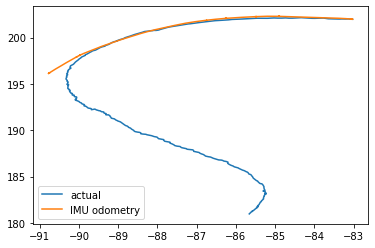

In [13]:
lim = 600
plt.plot(cs_actual_x, cs_actual_y, label='actual')
plt.plot(p_2d[:lim,0], p_2d[:lim, 1], label='IMU odometry')
plt.legend()

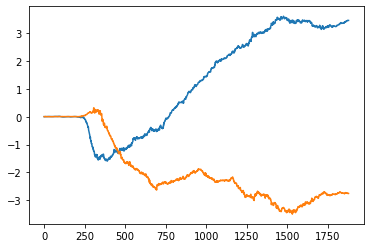

In [14]:
plt.plot(v_2d)

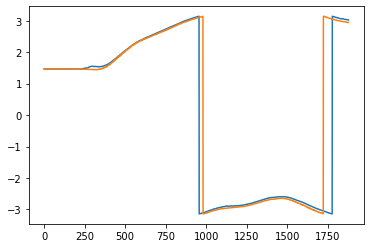

In [15]:
plt.plot(imu_rpy[:,-1])
plt.plot(wrap_angle(yaw))

# Class EKF 2D

In [16]:
import numpy as np
from numba import jitclass, float64, int64

In [17]:
class imu_ekf_2d(object):
    def __init__(self, p0, v0, yaw0, ba0, bw0, P0, Q, yawc):
        self.p = p0
        self.v = v0
        self.yaw = yaw0
        self.ba = ba0
        self.bw = bw0
        self.Q = Q
        self.P = P0
        self.yawc = yawc
        
        self.H_gnss = np.zeros((2,8))
        self.H_gnss[:,:2] = np.eye(2)
    def _wrap_angle(self, angle):
        return (angle + np.pi) % (2 * np.pi) - np.pi
    def _yaw_to_rot(self, y):
        return np.array([[np.cos(y), -np.sin(y)],
                         [np.sin(y), np.cos(y)]])
    def _yaw_to_rot_dot(self, y):
        return np.array([[-np.sin(y), -np.cos(y)],
                         [np.cos(y), -np.sin(y)]])
    def get_state(self):
        return self.p, self.v, self.yaw, self.ba, self.bw
    def get_cov_sys(self):
        return self.P
    def predict(self, dt, a, w):
        C = self._yaw_to_rot(self.yaw - self.yawc)
        C_dot = self._yaw_to_rot_dot(self.yaw - self.yawc)
        
        self.p = self.p + dt*self.v + dt**2/2 * C@(a - self.ba)
        self.v = self.v + dt* C@(a - self.ba)
        self.yaw = self.yaw + dt*(w - self.bw)
        self.ba = self.ba
        self.bw = self.bw
        
        F = np.eye(8)
        F[:2, 2:4] = np.eye(2) * dt
        F[:2, 4] = dt**2/2 * C_dot@(a - self.ba)
        F[:2, 5:7] = - dt**2/2 * C
        F[2:4, 4] = dt*C_dot@(a - self.ba)
        F[2:4, 5:7] = -dt * C
        F[4, 7] = -dt
        
        L = np.zeros((8,6))
        L[:2,:2] = dt**2/2 * C
        L[:2,3:5] = - dt**2/2 * C
        L[2:4,:2] = dt*C
        L[2:4,3:5] = -dt*C
        L[4,2] = dt
        L[4,5] = -dt
        L[5:,3:] = np.eye(3)
        
        Q = np.copy(self.Q)
        Q[:3,:3] = Q[:3,:3] * dt**2
        Q[3:,3:] = Q[3:,3:] * dt
        
        self.P = F @ self.P @ F.T + L @ Q @ L.T
    
    def _kalman_gain(self, H, J):
        return self.P @ H.T @ np.linalg.inv(H @ self.P @ H.T + J)
    
    def _correct_state_from_inno(self, dx):
        self.p = self.p + dx[:2]
        self.v = self.v + dx[2:4]
        self.yaw = self._wrap_angle(self.yaw + dx[4])
        self.ba = self.ba + dx[5:7]
        self.bw = self.bw + dx[7]
        
    def _correct_cov_sys(self, K, H, J):
        self.P = (np.eye(8) - K @ H) @ self.P @ (np.eye(8) - K @ H).T + K @ J @ K.T
        
    def correct_compass(self, y, J):
        None
        
    def correct_gnss_2d(self, g2d, J):
        K = self._kalman_gain(self.H_gnss, J)
        inno = g2d - self.p
        dx = np.dot(K, inno)
        
        self._correct_state_from_inno(dx)
        self._correct_cov_sys(K, self.H_gnss, J)
        

In [18]:
yawc_imu = np.pi/2
yawc_yaw = np.pi*3/2

imu_t_n = imu_t - imu_t[0]
gnss_t_n = gnss_t - gnss_t[0]

cp_2d = np.zeros_like(imu_a_2d)
cv_2d = np.zeros_like(imu_a_2d)
cyaw = np.zeros(imu_a_2d.shape[0])
cP_2d = np.ones((cv_2d.shape[0], 8, 8)) * 0.5
cba_2d = np.zeros_like(cp_2d)
cbw_2d = np.zeros_like(cyaw)

cp_2d[0,0] = cs_actual_x[0]
cp_2d[0,1] = cs_actual_y[0]
# cyaw[0] = imu_rpy[0,-1]
cyaw[0] = wrap_angle(imu_rpy[0,-1] - yawc_yaw)
cba_2d[0] = bias_a_2d
cbw_2d[0] = bias_w_2d

var_a = 0.5
var_w = 0.1
var_ba = 0.5
var_bw = 0.001

Q = np.zeros((6,6))
Q[:2,:2] = np.eye(2) * var_a
Q[2,2] = var_w
Q[3:5, 3:5] = np.eye(2) * var_ba
Q[5, 5] = var_bw

J_gnss = np.eye(2) * 4

In [19]:
ekf = imu_ekf_2d(cp_2d[0], cv_2d[0], cyaw[0], bias_a_2d, bias_w_2d, cP_2d[0], Q, yawc_imu)

In [20]:
gnss_idx = 1
for k in range(1, imu_a.shape[0]):
    dt = imu_t[k] - imu_t[k - 1]
    
    if (gnss_idx != gnss_t.shape[0]) and (gnss_t_n[gnss_idx] <= imu_t_n[k-1]):
        ekf.correct_gnss_2d(gnss_p[gnss_idx], J_gnss)
        gnss_idx = gnss_idx + 1
    ekf.predict(dt, imu_a_2d[k-1], imu_w_2d[k-1])
    
    cp_2d[k], cv_2d[k], cyaw[k], cba_2d[k], cbw_2d[k] = ekf.get_state()
    cP_2d[k] = ekf.get_cov_sys()

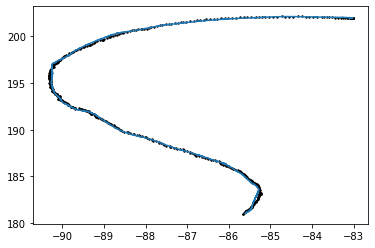

In [21]:
plt.plot(cp_2d[:,0], cp_2d[:,1])
plt.scatter(gnss_p[:,0], gnss_p[:,1],s=2.,color='black')
plt.show()

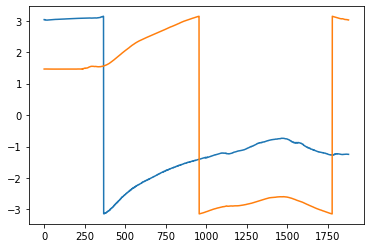

In [22]:
plt.plot(wrap_angle(cyaw))
plt.plot(imu_rpy[:,-1])

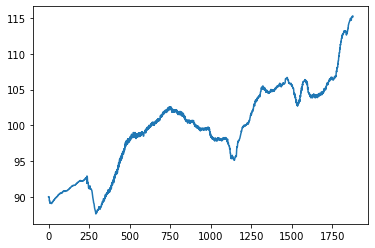

In [23]:
plt.plot(wrap_angle(cyaw-imu_rpy[:,-1])*180/np.pi)

In [24]:
# plt.plot(np.linalg.norm(cv_2d,axis=-1))
# plt.plot(cbw_2d)
# plt.plot(cba_2d)

# Yaw Comparison

In [25]:
dgnss = gnss_p[2:] - gnss_p[:-2]
gnss_yaw = np.zeros(gnss_t.shape[0])
gnss_yaw[1:-1] = np.arctan2(dgnss[:,-1], dgnss[:,0])
gnss_yaw[0] = gnss_yaw[1]
gnss_yaw[-1] = gnss_yaw[-2]

In [26]:
gnss_yaw[1:-1].shape

(528,)

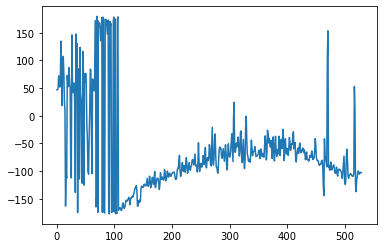

In [27]:
plt.plot((gnss_yaw*180./np.pi)[:])

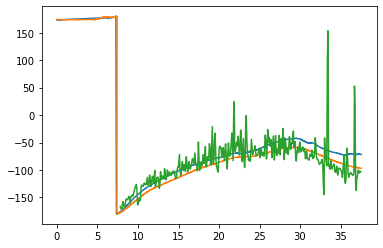

In [28]:
plt.plot(imu_t-imu_t[0], wrap_angle(cyaw)*180/np.pi)
plt.plot(imu_t-imu_t[0], wrap_angle(imu_rpy[:,-1]-np.pi*3/2)*180/np.pi)
lim1 = 110
lim2 = -1
plt.plot(gnss_t[lim1:lim2]-gnss_t[0], (gnss_yaw*180./np.pi)[lim1:lim2])
# plt.xlim(10,15)
# plt.ylim(-160,-70)